# Project 02 

## Part 1 - Requirements

The city is going to launch a new bike sharing system. Your task is to design a relational database to support its operation. The bike sharing system works as follows:

1. Riders can buy annual, semiannual or monthly membership. We need to have a record of each member's name and address in order to send them a key. Keys can be used to check out bikes at any bike station. Members have the option to renew their memberships before they expire. A member becomes inactive when his or her membership expires, therefore we need to know when their memberships expire. 

1. Each bike station has a pubic name (i.e. "18th & C St NW"). Occasionally in response to public requests, stations can be renamed. Each bike station have been built with a number of docking points.

1. Each bike is either serviceable or disabled. If it is disabled, it is removed from the station for repair.

1. For simplicity's sake, each serviceable bike is either docked at a station or checked out by a member. If it is checked out by a member, the system needs to know who has checked it out and when.

Your database should minimally support the above requirements.

## Part 2 - Designing a Database Schema (35 points)

Based on what you read above, design a relational database schema consisting of *at least* 3 tables. Document your schema with a schema diagram.  There are several tools available for this, such as [Google Drawings](https://docs.google.com/drawings/) and Microsoft Visio. Make sure to include the schema diagram in your submission. Embed and display the diagram in your notebook. **Discuss your major design decisions.** Be aware that your schema is designed to support transaction processing and should be optimized for writes and data consistency.

We are looking for the following when grade this part of the project:

* All required attributes are recorded.
* In the schema diagram, all primary keys are underlined. Directed lines are drawn from the foreign keys to the primary keys.
* Your database schema should be designed to promite data consistency and integrity and reduce the duplication of data. Strive for 3NF.
* Your database schema should be designed to support the requirements described in Part 1, as well as problems in Part 4 and 5.
* Key design decisions are discussed and documented in Markdown cells.

See slide 23 of week-04 lecture for an example of schema diagram. 

**Schema Design Description**

Our schema diagram contains five tables: membership, station, bike, check_in and check_out. The membership table records rider personal information and their membership information. We first planned to put membership type as a separate table, which would be easier to update new membership type and reduce redundancy. However, we found out that we were incapable to create data for all the attributes in these two separate tables, so we combine them together as one membership table. We believe that keeping membership type as an independent table will be a better practice in the real world scenario. Both station and bike tables are just simply record station and bike information respectively. We connect these two tables through the bike.current_station_id and station.station_id. Current_station_id could be null because bikes do not have to be park at the station. They could be either ridden by a member or sent to fix.  Finally, we have check in and check out tables. These tables are used to check all the rental records of each bike. Separating these two tables would be easier to update record.

**Schema Diagram**

Here please upload 'proj2.png' attached to your notebook, thanks.

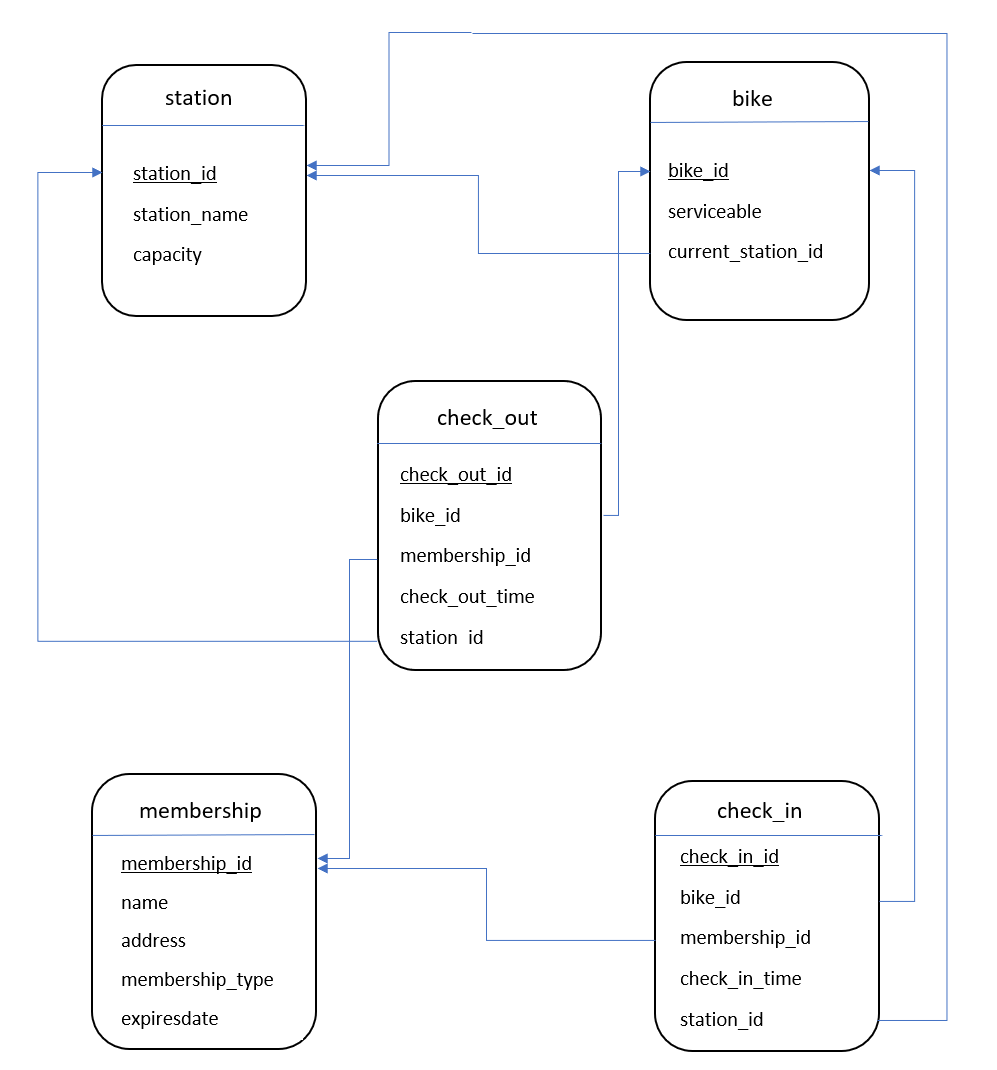

In [1]:
from IPython.display import Image
Image(filename='proj2.png')

## Part 3 - ETL (30 points)
Please use markdown cells to **document major steps**. Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 3.1
Examine the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv.
Create and connect to a new PostgreSQL database named `proj2`. Use SQL DDL to create your tables in it based on the database schema you designed in Part 2 and the data. Don't forget about the contraints (primary keys, foreign keys, proper attribute types, NOT NULL etc).

First, drop the database named `proj2` if it exists. It is necessary so that we can run this notebook repeatedly. If you get the error that says "database proj2 does not exist", that is fine. However if it complains that "There is 1 other session using the database", please restart the Kernel and try it again.

In [2]:
!dropdb -U student proj2

In [3]:
!createdb -U student proj2

To use sql magic to connect to the database we just created. 

In [4]:
%load_ext sql

In [5]:
%sql postgresql://student@/proj2

'Connected: student@proj2'

To download the csv file from the website

In [6]:
!wget https://s3.amazonaws.com/dmfa-2017/bike_stations.csv

--2017-10-13 15:55:31--  https://s3.amazonaws.com/dmfa-2017/bike_stations.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.112.179
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.112.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169879 (166K) [text/csv]
Saving to: ‘bike_stations.csv’

bike_stations.csv   100%[===================>] 165.90K  --.-KB/s    in 0.004s  

2017-10-13 15:55:31 (38.0 MB/s) - ‘bike_stations.csv’ saved [169879/169879]



To rename the file for convenience considerations

In [7]:
!mv bike_stations.csv project2.csv

To have a glance at this csv file to determine its attributes' domains and ranges

In [8]:
!wc -l project2.csv

4318 project2.csv


In [9]:
!csvcut -n project2.csv

  1: Bike number
  2: Bike serviceable
  3: Station number
  4: Station name
  5: Station capacity


In [10]:
!csvstat project2.csv

  1. Bike number
	<class 'str'>
	Nulls: True
	Unique values: 4298
	Max length: 6
  2. Bike serviceable
	<class 'bool'>
	Nulls: True
	Unique values: 2
	5 most frequent values:
		True:	3823
		False:	475
  3. Station number
	<class 'int'>
	Nulls: True
	Min: 31000
	Max: 32223
	Sum: 120781045
	Mean: 31437.023685580425
	Median: 31308.5
	Standard Deviation: 340.9347635158527
	Unique values: 452
	5 most frequent values:
		31623:	49
		31101:	41
		31639:	36
		31622:	33
		31268:	32
  4. Station name
	<class 'str'>
	Nulls: True
	Unique values: 452
	5 most frequent values:
		Columbus Circle / Union Station:	49
		14th & V St NW:	41
		2nd & G St NE:	36
		13th & D St NE:	33
		12th & U St NW:	32
	Max length: 64
  5. Station capacity
	<class 'int'>
	Nulls: True
	Min: 1
	Max: 51
	Sum: 72408
	Mean: 18.846434148880792
	Median: 17.0
	Standard Deviation: 8.857560379946257
	Unique values: 36
	5 most frequent values:
		17:	254
		16:	247
		19:	208
		28:	177
		13:	173

Row count: 4317


To create the five tables illustrated in our schema diagram

In [11]:
%%sql
DROP TABLE IF EXISTS check_in;
DROP TABLE IF EXISTS check_out;
DROP TABLE IF EXISTS membership;
DROP TABLE IF EXISTS bike;
DROP TABLE IF EXISTS station;

CREATE TABLE membership (
    membership_id SERIAL NOT NULL PRIMARY KEY,
    name VARCHAR NOT NULL,
    address VARCHAR NOT NULL,
    membership_type VARCHAR NOT NULL,
    expiresdate TIMESTAMP NOT NULL
);

CREATE TABLE station (
    station_id INTEGER NOT NULL PRIMARY KEY,
    station_name VARCHAR(64) NOT NULL,
    capacity INTEGER NOT NULL
);

CREATE TABLE bike (
    bike_id VARCHAR(6) NOT NULL PRIMARY KEY,
    serviceable BOOLEAN NOT NULL,
    current_station_id INTEGER REFERENCES station(station_id)
);

CREATE TABLE check_in (
    check_in_id SERIAL NOT NULL PRIMARY KEY, 
    bike_id VARCHAR(6) NOT NULL REFERENCES bike(bike_id),
    membership_id INTEGER NOT NULL REFERENCES membership(membership_id), 
    check_in_time TIMESTAMP NOT NULL, 
    station_id INTEGER NOT NULL REFERENCES station(station_id)
); 

CREATE TABLE check_out (
    check_out_id SERIAL NOT NULL PRIMARY KEY, 
    bike_id VARCHAR(6) NOT NULL REFERENCES bike(bike_id), 
    membership_id INTEGER NOT NULL REFERENCES membership(membership_id), 
    check_out_time TIMESTAMP NOT NULL, 
    station_id INTEGER NOT NULL REFERENCES station(station_id)
)

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

**Comment**

SERIAL enables PostgreSQL automatically assigns the value of the column when a new record is add, and the values are from small to large (arithmetic progression with difference = 1). Since the csv doesn't provide the information for membership, check-in and check-out, we can use SERIAL to create the primary keys for these three tables for convenience.

### Problem 3.2
Use the data located at https://s3.amazonaws.com/dmfa-2017/bike_stations.csv to populate your database. You may import the CSV file content into a temporary table in your database `proj2`. Just remember to remove it after you are done. 

Since the data doesn't include information about members, you will need to make up a few (4 or 5) members in your database. Some of their memberships have expired.

To recall the characteristics of the csv file for creating a temporary table

In [12]:
!csvstat project2.csv

  1. Bike number
	<class 'str'>
	Nulls: True
	Unique values: 4298
	Max length: 6
  2. Bike serviceable
	<class 'bool'>
	Nulls: True
	Unique values: 2
	5 most frequent values:
		True:	3823
		False:	475
  3. Station number
	<class 'int'>
	Nulls: True
	Min: 31000
	Max: 32223
	Sum: 120781045
	Mean: 31437.023685580425
	Median: 31308.5
	Standard Deviation: 340.9347635158527
	Unique values: 452
	5 most frequent values:
		31623:	49
		31101:	41
		31639:	36
		31622:	33
		31268:	32
  4. Station name
	<class 'str'>
	Nulls: True
	Unique values: 452
	5 most frequent values:
		Columbus Circle / Union Station:	49
		14th & V St NW:	41
		2nd & G St NE:	36
		13th & D St NE:	33
		12th & U St NW:	32
	Max length: 64
  5. Station capacity
	<class 'int'>
	Nulls: True
	Min: 1
	Max: 51
	Sum: 72408
	Mean: 18.846434148880792
	Median: 17.0
	Standard Deviation: 8.857560379946257
	Unique values: 36
	5 most frequent values:
		17:	254
		16:	247
		19:	208
		28:	177
		13:	173

Row count: 4317


To create a temporary table

In [13]:
%%sql
CREATE TABLE rides (
    bike_id VARCHAR(6),
    serviceable BOOLEAN,
    station_id INTEGER,
    station_name VARCHAR(64),
    capacity INTEGER
)

Done.


[]

To find current directory

In [14]:
!pwd

/home/ubuntu


To load the data using COPY

In [15]:
%%sql
COPY rides FROM '/home/ubuntu/project2.csv'
CSV
HEADER;

4317 rows affected.


[]

To check whether we have successfully and correctly loaded the data

In [16]:
%%sql
SELECT COUNT(*) FROM rides;

1 rows affected.


count
4317


In [17]:
%%sql
SELECT *
FROM rides
LIMIT 10

10 rows affected.


bike_id,serviceable,station_id,station_name,capacity
W00005,True,32011,Maple & Ritchie Ave,28
W00174,True,31246,M St & Pennsylvania Ave NW,10
W00196,True,31408,Takoma Metro,12
W00216,True,31309,Fessenden St & Wisconsin Ave NW,8
W00267,True,31125,15th & W St NW,24
W00310,True,31056,S Troy St & 26th St S,9
W00338,True,31244,4th & E St SW,19
W00388,True,32023,Montgomery College/W Campus Dr & Mannakee St,8
W00403,True,31217,USDA / 12th & Independence Ave SW,10
W00409,True,31402,14th St Heights / 14th & Crittenden St NW,6


To insert the station id number, name and capacity into our 'station' table

In [18]:
%%sql
INSERT INTO station
    SELECT DISTINCT station_id, station_name, capacity
    FROM rides
    WHERE station_id IS NOT NULL
    AND station_name IS NOT NULL
    AND capacity IS NOT NULL

452 rows affected.


[]

**Comment** Here we use DISTINCT because there are lots of repeated values of the station id and name in the csv, which indicates that there are some bikes docked in the same station.

To see if we successfully insert the data into table 'station'

In [19]:
%%sql
SELECT *
FROM station
LIMIT 10

10 rows affected.


station_id,station_name,capacity
31221,18th & M St NW,13
31287,10th St & L'Enfant Plaza SW,8
31507,1st & Washington Hospital Center NW,8
31119,14th & Belmont St NW,14
32010,Philadelphia & Maple Ave,28
31501,12th & Newton St NE,5
31313,Connecticut Ave & Tilden St NW,8
32034,Ripley & Bonifant St,8
31603,1st & M St NE,17
31909,Mount Vernon Ave & Four Mile Run Park,13


To insert the bike number and bike serviceable information into our 'bike' table

In [20]:
%%sql
INSERT INTO bike
    SELECT DISTINCT bike_id, serviceable, station_id
    FROM rides
    WHERE bike_id IS NOT NULL
    AND serviceable IS NOT NULL

4298 rows affected.


[]

**Comment** Here we use DISTINCT to avoid repeated values of bike_id to be added into the primary key column.

To see if we successfully insert the data into table 'bike'

In [21]:
%%sql
SELECT *
FROM bike
LIMIT 10

10 rows affected.


bike_id,serviceable,current_station_id
W00770,True,31639
W22671,True,31803
W20231,True,31638
W22541,True,31281
W21508,True,31108
W20304,True,31626
W00178,False,None
W20678,True,31643
W20823,True,31076
W22337,True,31240


To remove the temporary table 'rides'

In [22]:
%%sql
DROP TABLE rides

Done.


[]

To make up some records into the table 'membership'

In [23]:
%%sql
INSERT INTO membership (name, address, membership_type, expiresdate)
VALUES 
    ('John Smith', '320 23rd St. S, Arlington, VA 22202', 'semiannual', '2017-01-01'),
    ('Jimmy Lee', '157 St. F, Washington, DC 20052', 'annual', '2017-11-10'),
    ('Yvonne Rice', '222 St. E, Washington, DC 20052', 'monthly', '2017-05-15'),
    ('Wu Chan', '3505 International Place, N.W., Washington, DC 20008', 'annual', '2018-05-20'),
    ('Elisa G. Clinton', '2201 St. G, N.W., Washington, DC 20052', 'monthly', '2017-11-12')

5 rows affected.


[]

To see if we successfully insert the data into table 'membership'

In [24]:
%%sql
SELECT *
FROM membership

5 rows affected.


membership_id,name,address,membership_type,expiresdate
1,John Smith,"320 23rd St. S, Arlington, VA 22202",semiannual,2017-01-01 00:00:00
2,Jimmy Lee,"157 St. F, Washington, DC 20052",annual,2017-11-10 00:00:00
3,Yvonne Rice,"222 St. E, Washington, DC 20052",monthly,2017-05-15 00:00:00
4,Wu Chan,"3505 International Place, N.W., Washington, DC 20008",annual,2018-05-20 00:00:00
5,Elisa G. Clinton,"2201 St. G, N.W., Washington, DC 20052",monthly,2017-11-12 00:00:00


**Comment** Because the csv file does not include the check in/out time and rider information, we leave the tables 'check_in' and 'check_out' blank here, but we can insert records easily.

## Part 4 - Operations (15 points)
Use SQL queries and markdown cells to demonstrate that records are created or updated successfully.

### Problem 4.1
The bike 'W20131' is having mechanical problems and needs to be repaired off-site. Use SQL UPDATE statements to record the fact that this bike is no longer serviceable and has been removed from the station where it was docked at.

In [25]:
%%sql
UPDATE bike
SET serviceable = false, current_station_id = NULL
WHERE bike_id = 'W20131'

1 rows affected.


[]

To see if update successfully

In [26]:
%%sql
SELECT *
FROM bike
WHERE bike_id = 'W20131'

1 rows affected.


bike_id,serviceable,current_station_id
W20131,False,None


Yes, we update it correctly.

### Problem 4.2
The bike station at Adams Mill & Columbia Rd NW has been expanded. Use SQL UPDATE statements to change the name of the bike station from "Adams Mill & Columbia Rd NW" to "18th & Columbia Rd NW" and increase its capacity by 10.

To see the initial information of the station to check our updated results later

In [27]:
%%sql
SELECT *
FROM station
WHERE station_name = 'Adams Mill & Columbia Rd NW'

1 rows affected.


station_id,station_name,capacity
31104,Adams Mill & Columbia Rd NW,4


To update the information as required

In [28]:
%%sql
UPDATE station
SET station_name = '18th & Columbia Rd NW', capacity = capacity + 10
WHERE station_name = 'Adams Mill & Columbia Rd NW'

1 rows affected.


[]

To see if update successfully compared with the former one which has been illustrated above

In [29]:
%%sql
SELECT *
FROM station
WHERE station_name = '18th & Columbia Rd NW'

1 rows affected.


station_id,station_name,capacity
31104,18th & Columbia Rd NW,14


Yes, we update it correctly.

### Problem 4.3
Use SQL UPDATE and/or INSERT statements to record the transaction that an active member checked out the bike 'W00005' from station 'Maple & Ritchie Ave' at '2017-10-01 08:46:00'.

To insert a record into table 'check_out' and update the current station information for this bike

In [30]:
%%sql
INSERT INTO check_out(bike_id, membership_id, check_out_time, station_id)
VALUES ('W00005', 4, '2017-10-01 08:46:00', 
       (SELECT station_id
       FROM station
       WHERE station_name = 'Maple & Ritchie Ave' ));

UPDATE bike
SET current_station_id = NULL
WHERE bike_id = 'W00005'

1 rows affected.
1 rows affected.


[]

To see if we insert this record successfully

In [31]:
%%sql
SELECT *
FROM check_out

1 rows affected.


check_out_id,bike_id,membership_id,check_out_time,station_id
1,W00005,4,2017-10-01 08:46:00,32011


In [32]:
%%sql
SELECT *
FROM bike
WHERE bike_id = 'W00005'

1 rows affected.


bike_id,serviceable,current_station_id
W00005,True,None


Yes, we insert the record correctly.

## Part 5 - Queries (20 points)

Use SQL SELECT statements to answer the following questions. Use markdown cells to explain your SQL statements and results if needed.

### Problem 5.1
For all members, display their name, membership type (annual, semiannual or monthly, in readable text), membership status (active or expired, boolean value is fine) and the date when the membership expires.

In [33]:
%%sql
SELECT name, membership_type, 
    (case when expiresdate > now() then 'active' else 'expired' end) as "membership status", expiresdate
FROM membership

5 rows affected.


name,membership_type,membership status,expiresdate
John Smith,semiannual,expired,2017-01-01 00:00:00
Jimmy Lee,annual,active,2017-11-10 00:00:00
Yvonne Rice,monthly,expired,2017-05-15 00:00:00
Wu Chan,annual,active,2018-05-20 00:00:00
Elisa G. Clinton,monthly,active,2017-11-12 00:00:00


We struggled a lot for this problem but the results above do not agree with the hint. We are sorry for some of the codes might be false, and we would appreciate it if you can give us some advice.

### Problem 5.2
Display the top 10 stations which currently have the most bikes docked. For each station, list the station name and the total number of bikes docked there.

In [35]:
%%sql 
SELECT station.station_name, count(bike.current_station_id) as capacity_used
FROM station
JOIN bike
   ON station.station_id=bike.current_station_id
GROUP BY station.station_id
ORDER BY capacity_used DESC
LIMIT 10;

10 rows affected.


station_name,capacity_used
Columbus Circle / Union Station,49
14th & V St NW,41
2nd & G St NE,36
13th & D St NE,33
12th & U St NW,32
11th & Kenyon St NW,29
1st & N St SE,28
4th & M St SW,27
6th & H St NE,27
13th & H St NE,27


### Problem 5.3
Display the first 10 stations based on their names in ascending order. For each station, list station name and the number of available docking points accepting bike returns. Verify the numbers are correct.

In [36]:
%%sql 
SELECT station.station_name, station.capacity - count(bike.current_station_id) as capacity_left
FROM station
JOIN bike
   ON station.station_id=bike.current_station_id
GROUP BY station.station_id
ORDER BY station.station_name
LIMIT 10

10 rows affected.


station_name,capacity_left
10th & E St NW,2
10th & Florida Ave NW,5
10th & G St NW,8
10th & K St NW,6
10th & Monroe St NE,2
10th St & Constitution Ave NW,5
10th St & L'Enfant Plaza SW,7
10th & U St NW,2
11th & F St NW,2
11th & H St NE,3


To verify

In [37]:
%%sql 
SELECT station.station_name, count(bike.current_station_id) as capacity_used
FROM station
JOIN bike
   ON station.station_id=bike.current_station_id
GROUP BY station.station_id
ORDER BY station.station_name
LIMIT 10

10 rows affected.


station_name,capacity_used
10th & E St NW,15
10th & Florida Ave NW,16
10th & G St NW,6
10th & K St NW,8
10th & Monroe St NE,1
10th St & Constitution Ave NW,8
10th St & L'Enfant Plaza SW,1
10th & U St NW,15
11th & F St NW,6
11th & H St NE,20


In [38]:
%%sql
SELECT station_name, capacity
FROM station
ORDER BY station.station_name
LIMIT 10

10 rows affected.


station_name,capacity
10th & E St NW,17
10th & Florida Ave NW,21
10th & G St NW,14
10th & K St NW,14
10th & Monroe St NE,3
10th St & Constitution Ave NW,13
10th St & L'Enfant Plaza SW,8
10th & U St NW,17
11th & F St NW,8
11th & H St NE,23


Based on our own calculation, we can see that capacity left from query is right.